Proyek Sistem Rekomendasi Film

Pendahuluan

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi film menggunakan dataset MovieLens 100K. Kita akan mengimplementasikan dua pendekatan: Content-based Filtering dan Collaborative Filtering.

Import Library dan Mount Google Drive

In [ ]:
!pip install scikit-surprise
!pip install pandas numpy scikit-learn surprise streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=f68596d1ce701b4d5373ca0264d07684e0178b0c2c5a25af4d0033d86220bb4e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: te

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import os
import zipfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory to the project folder
project_path = '/content/drive/My Drive/Recommendation System Project'
os.chdir(project_path)

# Unzip the ml-100k.zip file
with zipfile.ZipFile('ml-100k.zip', 'r') as zip_ref:
    zip_ref.extractall('ml-100k')

Mounted at /content/drive


Pada tahap ini, kita mengimpor semua library yang diperlukan, me-mount Google Drive untuk mengakses dataset, dan mengekstrak file zip yang berisi dataset.

Data Understanding

In [3]:
# Load the MovieLens 100K dataset
movies_df = pd.read_csv('ml-100k/ml-100k/u.item', sep='|', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
ratings_df = pd.read_csv('ml-100k/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

print("Movies dataset shape:", movies_df.shape)
print("Ratings dataset shape:", ratings_df.shape)

# Display first few rows of each dataset
print("\nFirst few rows of movies dataset:")
print(movies_df.head())
print("\nFirst few rows of ratings dataset:")
print(ratings_df.head())

Movies dataset shape: (1682, 24)
Ratings dataset shape: (100000, 4)

First few rows of movies dataset:
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-N

Di sini, kita membaca dataset MovieLens 100K yang terdiri dari dua file utama: u.item (informasi film) dan u.data (rating user). Kita menampilkan shape dan beberapa baris pertama dari kedua dataset untuk memahami strukturnya.

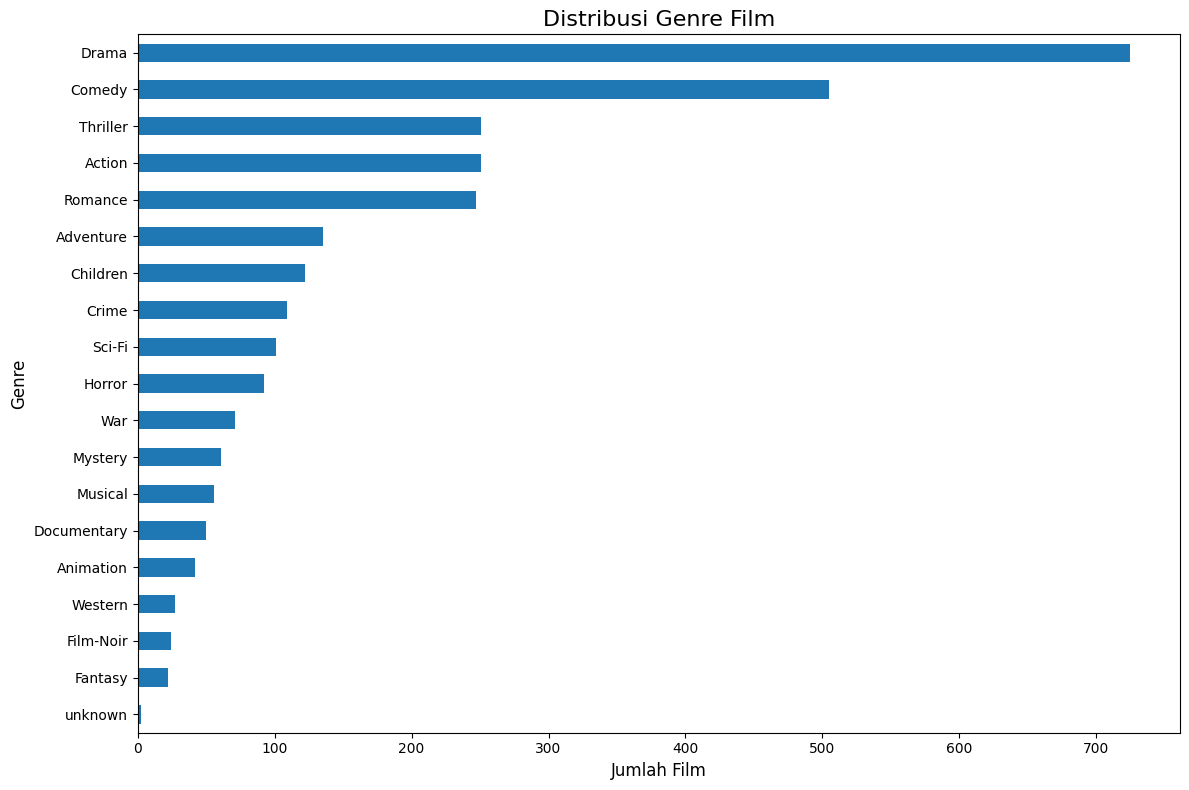

Visualisasi telah disimpan sebagai 'genre_distribution.png'


In [7]:
# Import necessary library
import matplotlib.pyplot as plt

# Daftar genre
movie_genres = {
    'unknown': 'Unknown', 'Action': 'Action', 'Adventure': 'Adventure',
    'Animation': 'Animation', 'Children': "Children's", 'Comedy': 'Comedy', # Change "Children's" to "Children"
    'Crime': 'Crime', 'Documentary': 'Documentary', 'Drama': 'Drama',
    'Fantasy': 'Fantasy', 'Film-Noir': 'Film-Noir', 'Horror': 'Horror',
    'Musical': 'Musical', 'Mystery': 'Mystery', 'Romance': 'Romance',
    'Sci-Fi': 'Sci-Fi', 'Thriller': 'Thriller', 'War': 'War', 'Western': 'Western'
}

# Hitung frekuensi setiap genre
genre_counts = movies_df[list(movie_genres.keys())].sum().sort_values(ascending=True)

# Buat visualisasi
plt.figure(figsize=(12, 8)) # Now plt is defined and can be used
genre_counts.plot(kind='barh')
plt.title('Distribusi Genre Film', fontsize=16)
plt.xlabel('Jumlah Film', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()

# Simpan gambar
plt.savefig('genre_distribution.png', dpi=300, bbox_inches='tight')

# Tampilkan plot (opsional jika Anda menjalankan kode di lingkungan yang mendukung visualisasi)
plt.show()

print("Visualisasi telah disimpan sebagai 'genre_distribution.png'")

Menghitung frekuensi setiap genre dalam dataset.

Membuat visualisasi bar plot horizontal menggunakan matplotlib.

Data Preparation

In [8]:
# Create a string of genres for each movie
movies_df['genres'] = movies_df[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].apply(lambda x: ' '.join(x.index[x == 1].tolist()), axis=1)

# Display the first few rows to check the new 'genres' column
print(movies_df[['title', 'genres']].head())

# Merge movies and ratings dataframes
movie_ratings = pd.merge(movies_df, ratings_df, on='movie_id')
print("\nMerged dataset shape:", movie_ratings.shape)
print(movie_ratings.head())

               title                     genres
0   Toy Story (1995)  Animation Children Comedy
1   GoldenEye (1995)  Action Adventure Thriller
2  Four Rooms (1995)                   Thriller
3  Get Shorty (1995)        Action Comedy Drama
4     Copycat (1995)       Crime Drama Thriller

Merged dataset shape: (100000, 28)
   movie_id             title release_date  video_release_date  \
0         1  Toy Story (1995)  01-Jan-1995                 NaN   
1         1  Toy Story (1995)  01-Jan-1995                 NaN   
2         1  Toy Story (1995)  01-Jan-1995                 NaN   
3         1  Toy Story (1995)  01-Jan-1995                 NaN   
4         1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...        

Pada tahap ini, kita melakukan beberapa langkah persiapan data:

1. Membuat string genre untuk setiap film

2. Menggabungkan informasi film dengan rating

Content-based Filtering

In [9]:
# Create TF-IDF matrix of genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on content
def get_content_based_recommendations(title, cosine_sim=cosine_sim):
    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Get recommendations for a sample movie
sample_movie = "Toy Story (1995)"
print(f"Content-based recommendations for '{sample_movie}':")
print(get_content_based_recommendations(sample_movie))

Content-based recommendations for 'Toy Story (1995)':
421                Aladdin and the King of Thieves (1996)
101                                Aristocats, The (1970)
403                                      Pinocchio (1940)
624                        Sword in the Stone, The (1963)
945                         Fox and the Hound, The (1981)
968           Winnie the Pooh and the Blustery Day (1968)
1065                                         Balto (1995)
1077                              Oliver & Company (1988)
1408                            Swan Princess, The (1994)
1411    Land Before Time III: The Time of the Great Gi...
Name: title, dtype: object


Dalam pendekatan ini:

1. Kita menggunakan TF-IDF untuk mengubah string genre menjadi vektor numerik

2. Menghitung cosine similarity antara film berdasarkan vektor genre

3. Membuat fungsi untuk mendapatkan rekomendasi film berdasarkan kemiripan konten

Collaborative Filtering

In [10]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Train the SVD model
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

# Function to get movie recommendations based on collaborative filtering
def get_collaborative_recommendations(user_id, n=10):
    # Get all movies the user hasn't rated
    user_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id']
    movies_to_predict = movies_df[~movies_df['movie_id'].isin(user_movies)]['movie_id']

    # Predict ratings for all movies
    predictions = [svd.predict(user_id, movie_id) for movie_id in movies_to_predict]

    # Sort predictions by estimated rating
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Get movie titles
    recommended_movies = [movies_df[movies_df['movie_id'] == pred.iid]['title'].values[0] for pred in top_n]

    return recommended_movies

# Get recommendations for a sample user
sample_user = 1
print(f"\nCollaborative recommendations for user {sample_user}:")
print(get_collaborative_recommendations(sample_user))


Collaborative recommendations for user 1:
['Third Man, The (1949)', "Schindler's List (1993)", 'Close Shave, A (1995)', 'Secrets & Lies (1996)', '39 Steps, The (1935)', 'Quiet Man, The (1952)', 'Chinatown (1974)', 'Lawrence of Arabia (1962)', 'Ran (1985)', 'Casablanca (1942)']


Untuk Collaborative Filtering:

1. Kita menggunakan library Surprise untuk implementasi SVD (Singular Value Decomposition)

2. Membagi data menjadi training dan testing set

3. Melatih model SVD

4. Membuat fungsi untuk mendapatkan rekomendasi film berdasarkan pola rating user

Evaluasi Model

In [11]:
# Compute RMSE and MAE for Collaborative Filtering
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"\nCollaborative Filtering Evaluation:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Content-based Filtering evaluation (example)
sample_movie = "Toy Story (1995)"
print(f"\nContent-based recommendations for '{sample_movie}':")
print(get_content_based_recommendations(sample_movie))

# Collaborative Filtering evaluation (example)
sample_user = 1
print(f"\nCollaborative recommendations for user {sample_user}:")
print(get_collaborative_recommendations(sample_user))

RMSE: 0.9427
MAE:  0.7426

Collaborative Filtering Evaluation:
RMSE: 0.9427123236034345
MAE: 0.7425896879167189

Content-based recommendations for 'Toy Story (1995)':
421                Aladdin and the King of Thieves (1996)
101                                Aristocats, The (1970)
403                                      Pinocchio (1940)
624                        Sword in the Stone, The (1963)
945                         Fox and the Hound, The (1981)
968           Winnie the Pooh and the Blustery Day (1968)
1065                                         Balto (1995)
1077                              Oliver & Company (1988)
1408                            Swan Princess, The (1994)
1411    Land Before Time III: The Time of the Great Gi...
Name: title, dtype: object

Collaborative recommendations for user 1:
['Third Man, The (1949)', "Schindler's List (1993)", 'Close Shave, A (1995)', 'Secrets & Lies (1996)', '39 Steps, The (1935)', 'Quiet Man, The (1952)', 'Chinatown (1974)', 'Lawrence o

Kita mengevaluasi model dengan cara:

1. Menghitung RMSE dan MAE untuk model Collaborative Filtering

2. Menampilkan contoh rekomendasi Content-based Filtering untuk film "Toy Story (1995)"

3. Menampilkan contoh rekomendasi Collaborative Filtering untuk user 1

Kesimpulan

Dalam proyek ini, kita telah berhasil mengimplementasikan dua pendekatan sistem rekomendasi film.
Content-based Filtering berguna untuk merekomendasikan film berdasarkan kemiripan konten, sementara
Collaborative Filtering dapat menangkap pola preferensi user yang lebih kompleks.
Kedua pendekatan memiliki kelebihan masing-masing dan dapat digunakan secara komplementer
untuk meningkatkan kualitas rekomendasi.